# Data Mining Final Project - Saketh Lakshmanan

### Pre-processing the data

In [92]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load data from the CSV file
data = pd.read_csv('invoice_transactions.csv')

# Drop rows with missing values
data.dropna(inplace=True)

# Encode categorical variables (Description) using LabelEncoder
label_encoder = LabelEncoder()
data['Description'] = label_encoder.fit_transform(data['Description'])

# Convert 'Customer ID' to integer
data['Customer ID'] = data['Customer ID'].astype(int)

# Define features (X) and target (y)
X = data.drop('Customer ID', axis=1)  # Features: all columns except 'Customer ID'
y = data['Customer ID']  # Target variable: 'Customer ID'

## Using the RANDOM FOREST algorithm to reccomend the top 10 products in the dataset to future customers

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_proba = clf.predict_proba(X_test)

# Get the predicted probabilities for positive class (purchasing the product)
product_probabilities = y_pred_proba[:, 1]

# Recommend top N products for each customer
N = 10  # Number of products to recommend
top_products_indices = product_probabilities.argsort()[-N:][::-1]  # Indices of top N products
top_products = X_test.iloc[top_products_indices]  # Top N recommended products

### Display Results

In [94]:
# Convert the 'Description' column to object dtype (string)
top_products['Description'] = top_products['Description'].astype(str)

# Invert the label encoding to get original product descriptions
reversed_description = label_encoder.inverse_transform(top_products['Description'].astype(int))

# Replace the numerical representation with the original words in the DataFrame
top_products.loc[:, 'Description'] = reversed_description

# Replace the numerical representation with the original words in the DataFrame
top_products.loc[:, 'Description'] = reversed_description

top_products_formatted = top_products.reset_index(drop=True)

# Display the recommended products
print("Top Recommended Products:")
print(top_products_formatted)

Top Recommended Products:
                          Description  Quantity  Price
0        BLUE COAT RACK PARIS FASHION         3   4.95
1            LOVE BUILDING BLOCK WORD         3   5.95
2                             POSTAGE         3  18.00
3         RED COAT RACK PARIS FASHION         3   4.95
4  BOX OF 6 ASSORTED COLOUR TEASPOONS         6   4.25
5         INFLATABLE POLITICAL GLOBE         48   0.85
6   WOODEN PICTURE FRAME WHITE FINISH         6   2.10
7             MINI PAINT SET VINTAGE         36   0.65
8        SET 7 BABUSHKA NESTING BOXES         2   7.65
9    RED HANGING HEART T-LIGHT HOLDER        64   2.55


### 10 Fold Cross Validation (for random forest)

In [95]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Initialize variables to store TP, TN, FP, FN
tp_random_forest = tn_random_forest = fp_random_forest = fn_random_forest = 0

# Define the cross-validation strategy
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Iterate over the folds
for train_index, test_index in skf.split(X, y):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train the Random Forest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Update TP, TN, FP, FN counts
    for true_label, pred_label in zip(y_test, y_pred):
        if true_label == pred_label:
            if true_label == 1:
                tp_random_forest += 1
            else:
                tn_random_forest += 1
        else:
            if pred_label == 1:
                fp_random_forest += 1
            else:
                fn_random_forest += 1

tpr_random_forest = tn_random_forest/(tn_random_forest + fn_random_forest)
spc_random_forest = tn_random_forest/(fp_random_forest + tn_random_forest)
ppv_random_forest = tp_random_forest/((tp_random_forest + fp_random_forest)+1)
npv_random_forest = tn_random_forest/(tn_random_forest + fn_random_forest)
fpr_random_forest = fp_random_forest/(fp_random_forest + tn_random_forest)
fdr_random_forest = fp_random_forest/((fp_random_forest + tp_random_forest)+1)
fnr_random_forest = fn_random_forest/(fn_random_forest + tp_random_forest)
acc_random_forest = (tp_random_forest + tn_random_forest)/(tn_random_forest + tp_random_forest + tn_random_forest)
f1_random_forest = 2*tp_random_forest / (2*tp_random_forest + fp_random_forest + fn_random_forest)
tss_random_forest = (tp_random_forest/(tp_random_forest + fn_random_forest)) - (fp_random_forest/(fp_random_forest + tn_random_forest))
hss_random_forest = (2*(tp_random_forest*tn_random_forest - fp_random_forest*fn_random_forest))/(((tp_random_forest+fn_random_forest) * (fn_random_forest+tn_random_forest) * (tp_random_forest+fp_random_forest) * (fp_random_forest+tn_random_forest))+1)


### Confusion Matrix Metrics Table (random forest)

In [96]:
from tabulate import tabulate

# Define the metrics
metrics_data = [
    ["TN", tn_random_forest],
    ["FP", fp_random_forest],
    ["FN", fn_random_forest],
    ["TP", tp_random_forest]
]

# Create the table
table = tabulate(metrics_data, headers=["Metric", "Value"], tablefmt="fancy_grid", numalign="center")

# Print the table
print("\nOverall Metrics (Average of 10 Folds):")
print(table)


Overall Metrics (Average of 10 Folds):
╒══════════╤═════════╕
│ Metric   │  Value  │
╞══════════╪═════════╡
│ TN       │   78    │
├──────────┼─────────┤
│ FP       │    0    │
├──────────┼─────────┤
│ FN       │   22    │
├──────────┼─────────┤
│ TP       │    0    │
╘══════════╧═════════╛


### Extra Metrics (MANUALLY CALCULATED) Table

In [97]:
# Define the extra metrics
extra_metrics_data = [
    ["TPR (True Positive Rate)", tpr_random_forest],
    ["SPC (Specificity)", spc_random_forest],
    ["PPV (Positive Predictive Value)", ppv_random_forest],
    ["NPV (Negative Predictive Value)", npv_random_forest],
    ["FPR (False Positive Rate)", fpr_random_forest],
    ["FDR (False Discovery Rate)", fdr_random_forest],
    ["FNR (False Negative Rate)", fnr_random_forest],
    ["ACC (Accuracy)", acc_random_forest],
    ["F1 score", f1_random_forest],
    ["TSS (True Skill Statistic)", tss_random_forest],
    ["HSS (Heidke Skill Score)", hss_random_forest]
]

# Create the table
table_extra_metrics = tabulate(extra_metrics_data, headers=["Metric", "Value"], tablefmt="fancy_grid", numalign="center")

# Print the table
print("\nExtra Metrics (MANUALLY DONE):")
print(table_extra_metrics)


Extra Metrics (MANUALLY DONE):
╒═════════════════════════════════╤═════════╕
│ Metric                          │  Value  │
╞═════════════════════════════════╪═════════╡
│ TPR (True Positive Rate)        │  0.78   │
├─────────────────────────────────┼─────────┤
│ SPC (Specificity)               │    1    │
├─────────────────────────────────┼─────────┤
│ PPV (Positive Predictive Value) │    0    │
├─────────────────────────────────┼─────────┤
│ NPV (Negative Predictive Value) │  0.78   │
├─────────────────────────────────┼─────────┤
│ FPR (False Positive Rate)       │    0    │
├─────────────────────────────────┼─────────┤
│ FDR (False Discovery Rate)      │    0    │
├─────────────────────────────────┼─────────┤
│ FNR (False Negative Rate)       │    1    │
├─────────────────────────────────┼─────────┤
│ ACC (Accuracy)                  │   0.5   │
├─────────────────────────────────┼─────────┤
│ F1 score                        │    0    │
├─────────────────────────────────┼─────────┤
│ 

## Now using NAIVE BAYES to find the number of mislabeled points

In [98]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Load the dataset
data = pd.read_csv("invoice_transactions.csv")

# Extract features and target variable
X_text = data["Description"]
X_numeric = data[["Quantity", "Price"]]
y = data["Customer ID"]

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the text data
X_text_bow = vectorizer.fit_transform(X_text)

# Generate generic feature names for BoW features
bow_feature_names = [f"word_{i}" for i in range(X_text_bow.shape[1])]

# Concatenate text BoW features with numeric features
X = pd.concat([pd.DataFrame(X_text_bow.toarray(), columns=bow_feature_names), X_numeric], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Initialize a Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Fit the classifier to the training data and make predictions on the test data
y_pred = gnb.fit(X_train, y_train).predict(X_test)

# Calculate the number of mislabeled points
mislabeled_points = (y_test != y_pred).sum()
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], mislabeled_points))



Number of mislabeled points out of a total 50 points : 16


### 10 Fold Cross Validation (naive bayes)

In [99]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Define the cross-validation strategy
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize variables to store TP, TN, FP, FN
tp_naive = tn_naive = fp_naive = fn_naive = 0

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train Gaussian Naive Bayes classifier
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    # Predict labels for test set
    y_pred = gnb.predict(X_test)
    
    # Update TP, TN, FP, FN counts
    for true_label, pred_label in zip(y_test, y_pred):
        if true_label == pred_label:
            if true_label == 1:
                tp_naive += 1
            else:
                tn_naive += 1
        else:
            if pred_label == 1:
                fp_naive += 1
            else:
                fn_naive += 1

# Calculate additional metrics
tpr_naive = tn_naive/(tn_naive + fn_naive)
spc_naive = tn_naive/(fp_naive + tn_naive)
ppv_naive = tp_naive/((tp_naive + fp_naive)+1)
npv_naive = tn_naive/(tn_naive + fn_naive)
fpr_naive = fp_naive/(fp_naive + tn_naive)
fdr_naive = fp_naive/((fp_naive + tp_naive)+1)
fnr_naive = fn_naive/(fn_naive + tp_naive)
acc_naive = (tp_naive + tn_naive)/(fp_naive + fn_naive + tn_naive)
f1_naive = 2*tp_naive / (2*tp_naive + fp_naive + fn_naive)
tss_naive = (tp_naive/(tp_naive + fn_naive)) - (fp_naive/(fp_naive + tn_naive))
hss_naive = (2*(tp_naive*tn_naive - fp_naive*fn_naive))/(((tp_naive+fn_naive) * (fn_naive+tn_naive) * (tp_naive+fp_naive) * (fp_naive+tn_naive))+1)


### Confusion Matrix Metrics Table (naive bayes)

In [100]:
from tabulate import tabulate

# Define the metrics
metrics_data = [
    ["TP", tp_naive],
    ["TN", tn_naive],
    ["FP", fp_naive],
    ["FN", fn_naive]
    
]

# Create the table
table = tabulate(metrics_data, headers=["Metric", "Value"], tablefmt="fancy_grid", numalign="center")

# Print the table
print("\nOverall Metrics (Average of 10 Folds):")
print(table)



Overall Metrics (Average of 10 Folds):
╒══════════╤═════════╕
│ Metric   │  Value  │
╞══════════╪═════════╡
│ TP       │    0    │
├──────────┼─────────┤
│ TN       │   83    │
├──────────┼─────────┤
│ FP       │    0    │
├──────────┼─────────┤
│ FN       │   17    │
╘══════════╧═════════╛


### Extra Metrics (MANUALLY CALCULATED) Table

In [101]:
# Define the extra metrics
extra_metrics_data = [
    ["TPR (True Positive Rate)", tpr_naive],
    ["SPC (Specificity)", spc_naive],
    ["PPV (Positive Predictive Value)", ppv_naive],
    ["NPV (Negative Predictive Value)", npv_naive],
    ["FPR (False Positive Rate)", fpr_naive],
    ["FDR (False Discovery Rate)", fdr_naive],
    ["FNR (False Negative Rate)", fnr_naive],
    ["ACC (Accuracy)", acc_naive],
    ["F1 score", f1_naive],
    ["TSS (True Skill Statistic)", tss_naive],
    ["HSS (Heidke Skill Score)", hss_naive]
]

# Create the table
table_extra_metrics = tabulate(extra_metrics_data, headers=["Metric", "Value"], tablefmt="fancy_grid", numalign="center")

# Print the table
print("\nExtra Metrics (MANUALLY DONE):")
print(table_extra_metrics)


Extra Metrics (MANUALLY DONE):
╒═════════════════════════════════╤═════════╕
│ Metric                          │  Value  │
╞═════════════════════════════════╪═════════╡
│ TPR (True Positive Rate)        │  0.83   │
├─────────────────────────────────┼─────────┤
│ SPC (Specificity)               │    1    │
├─────────────────────────────────┼─────────┤
│ PPV (Positive Predictive Value) │    0    │
├─────────────────────────────────┼─────────┤
│ NPV (Negative Predictive Value) │  0.83   │
├─────────────────────────────────┼─────────┤
│ FPR (False Positive Rate)       │    0    │
├─────────────────────────────────┼─────────┤
│ FDR (False Discovery Rate)      │    0    │
├─────────────────────────────────┼─────────┤
│ FNR (False Negative Rate)       │    1    │
├─────────────────────────────────┼─────────┤
│ ACC (Accuracy)                  │  0.83   │
├─────────────────────────────────┼─────────┤
│ F1 score                        │    0    │
├─────────────────────────────────┼─────────┤
│ 

## Now using CONV1D to find the most common words in the description column

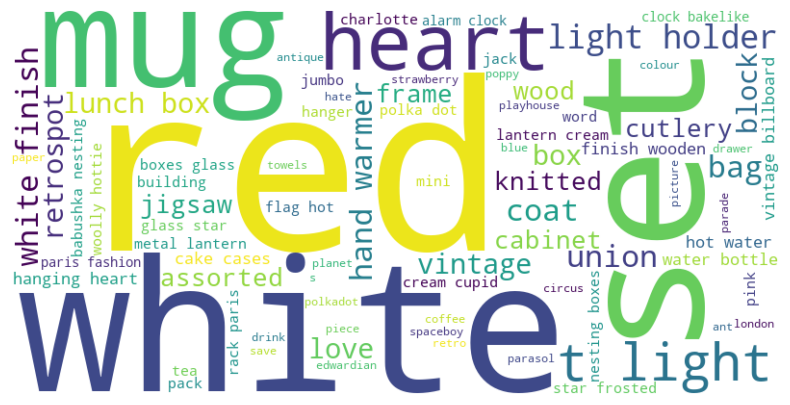

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load data from the CSV file
data = pd.read_csv('invoice_transactions.csv')

# Drop rows with missing values
data.dropna(inplace=True)

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    return text

# Apply text cleaning function to the Description column
data['Cleaned_Description'] = data['Description'].apply(clean_text)

# Join all cleaned descriptions into a single string
all_text = ' '.join(data['Cleaned_Description'].values)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 10 Fold Cross Verification (conv1d)

In [104]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Define the cross-validation strategy
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Reset the index of DataFrame X
X.reset_index(drop=True, inplace=True)

# Initialize variables to store TP, TN, FP, FN
tp_conv1d = tn_conv1d = fp_conv1d = fn_conv1d = 0
tp_conv1d_total = tn_conv1d_total = fp_conv1d_total = fn_conv1d_total = 0

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Reshape input data
    X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define model architecture
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Make predictions
    y_pred = (model.predict(X_test) > 0.5).astype("int32").reshape(-1)
    
    # Update TP, TN, FP, FN counts
    for true_label, pred_label in zip(y_test, y_pred):
        if true_label == pred_label:
            if true_label == 1:
                tp_conv1d += 1
            else:
                tn_conv1d += 1
        else:
            if pred_label == 1:
                fp_conv1d += 1
            else:
                fn_conv1d += 1
    
    # Accumulate counts for each iteration
    tp_conv1d_total += tp_conv1d
    tn_conv1d_total += tn_conv1d
    fp_conv1d_total += fp_conv1d
    fn_conv1d_total += fn_conv1d

tpr_conv1d = tn_conv1d/((tn_conv1d + fn_conv1d)+1)
spc_conv1d = tn_conv1d/(fp_conv1d + tn_conv1d)
ppv_conv1d = tp_conv1d/(tp_conv1d + fp_conv1d)
npv_conv1d = tn_conv1d/((tn_conv1d + fn_conv1d)+1)
fpr_conv1d = fp_conv1d/(fp_conv1d + tn_conv1d)
fdr_conv1d = fp_conv1d/(fp_conv1d + tp_conv1d)
fnr_conv1d = fn_conv1d/((fn_conv1d + tp_conv1d)+1)
acc_conv1d = (tp_conv1d + tn_conv1d)/(fp_conv1d + fn_conv1d + tn_conv1d)
f1_conv1d = 2*tp_conv1d / (2*tp_conv1d + fp_conv1d + fn_conv1d)
tss_conv1d = (tp_conv1d/(tp_conv1d + fn_conv1d +1)) - (fp_conv1d/(fp_conv1d + tn_conv1d +1))
hss_conv1d = (2*(tp_conv1d*tn_conv1d - fp_conv1d*fn_conv1d))/(((tp_conv1d+fn_conv1d) * (fn_conv1d+tn_conv1d) * (tp_conv1d+fp_conv1d) * (fp_conv1d+tn_conv1d))+1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


### Confusion Matrix Metrics Table (conv1D)

In [105]:
from tabulate import tabulate

# Define the metrics
metrics_data = [
    ["TP", tp_conv1d],
    ["TN", tn_conv1d],
    ["FP", fp_conv1d],
    ["FN", fn_conv1d]
    
]

# Create the table
table = tabulate(metrics_data, headers=["Metric", "Value"], tablefmt="fancy_grid", numalign="center")

# Print the table
print("\nOverall Metrics (Average of 10 Folds):")
print(table)


Overall Metrics (Average of 10 Folds):
╒══════════╤═════════╕
│ Metric   │  Value  │
╞══════════╪═════════╡
│ TP       │    0    │
├──────────┼─────────┤
│ TN       │    0    │
├──────────┼─────────┤
│ FP       │   100   │
├──────────┼─────────┤
│ FN       │    0    │
╘══════════╧═════════╛


### Extra Metrics (MANUALLY CALCULATED) Table

In [106]:
# Define the extra metrics
extra_metrics_data = [
    ["TPR (True Positive Rate)", tpr_conv1d],
    ["SPC (Specificity)", spc_conv1d],
    ["PPV (Positive Predictive Value)", ppv_conv1d],
    ["NPV (Negative Predictive Value)", npv_conv1d],
    ["FPR (False Positive Rate)", fpr_conv1d],
    ["FDR (False Discovery Rate)", fdr_conv1d],
    ["FNR (False Negative Rate)", fnr_conv1d],
    ["ACC (Accuracy)", acc_conv1d],
    ["F1 score", f1_conv1d],
    ["TSS (True Skill Statistic)", tss_conv1d],
    ["HSS (Heidke Skill Score)", hss_conv1d]
]

# Create the table
table_extra_metrics = tabulate(extra_metrics_data, headers=["Metric", "Value"], tablefmt="fancy_grid", numalign="center")

# Print the table
print("\nExtra Metrics (MANUALLY DONE):")
print(table_extra_metrics)


Extra Metrics (MANUALLY DONE):
╒═════════════════════════════════╤═══════════╕
│ Metric                          │   Value   │
╞═════════════════════════════════╪═══════════╡
│ TPR (True Positive Rate)        │     0     │
├─────────────────────────────────┼───────────┤
│ SPC (Specificity)               │     0     │
├─────────────────────────────────┼───────────┤
│ PPV (Positive Predictive Value) │     0     │
├─────────────────────────────────┼───────────┤
│ NPV (Negative Predictive Value) │     0     │
├─────────────────────────────────┼───────────┤
│ FPR (False Positive Rate)       │     1     │
├─────────────────────────────────┼───────────┤
│ FDR (False Discovery Rate)      │     1     │
├─────────────────────────────────┼───────────┤
│ FNR (False Negative Rate)       │     0     │
├─────────────────────────────────┼───────────┤
│ ACC (Accuracy)                  │     0     │
├─────────────────────────────────┼───────────┤
│ F1 score                        │     0     │
├───────

## Total Metrics for all three algorithms

In [107]:
# Define the metrics and their corresponding values
metrics = [
    ["Metric", "Random Forest", "Naive", "Conv1D"],
    ["TP", tp_random_forest, tp_naive, tp_conv1d],
    ["TN", tn_random_forest, tn_naive, tn_conv1d],
    ["FP", fp_random_forest, fp_naive, fp_conv1d],
    ["FN", fn_random_forest, fn_naive, fn_conv1d],
    ["TPR", tpr_random_forest, tpr_naive, tpr_conv1d],
    ["SPC", spc_random_forest, spc_naive, spc_conv1d],
    ["PPV", ppv_random_forest, ppv_naive, ppv_conv1d],
    ["NPV", npv_random_forest, npv_naive, npv_conv1d],
    ["FPR", fpr_random_forest, fpr_naive, fpr_conv1d],
    ["FDR", fdr_random_forest, fdr_naive, fdr_conv1d],
    ["FNR", fnr_random_forest, fnr_naive, fnr_conv1d],
    ["ACC", acc_random_forest, acc_naive, acc_conv1d],
    ["F1", f1_random_forest, f1_naive, f1_conv1d],
    ["TSS", tss_random_forest, tss_naive, tss_conv1d],
    ["HSS", hss_random_forest, hss_naive, hss_conv1d]
]

# Print the table
print(tabulate(metrics, headers="firstrow", tablefmt="fancy_grid"))

╒══════════╤═════════════════╤═════════╤════════════╕
│ Metric   │   Random Forest │   Naive │     Conv1D │
╞══════════╪═════════════════╪═════════╪════════════╡
│ TP       │            0    │    0    │   0        │
├──────────┼─────────────────┼─────────┼────────────┤
│ TN       │           78    │   83    │   0        │
├──────────┼─────────────────┼─────────┼────────────┤
│ FP       │            0    │    0    │ 100        │
├──────────┼─────────────────┼─────────┼────────────┤
│ FN       │           22    │   17    │   0        │
├──────────┼─────────────────┼─────────┼────────────┤
│ TPR      │            0.78 │    0.83 │   0        │
├──────────┼─────────────────┼─────────┼────────────┤
│ SPC      │            1    │    1    │   0        │
├──────────┼─────────────────┼─────────┼────────────┤
│ PPV      │            0    │    0    │   0        │
├──────────┼─────────────────┼─────────┼────────────┤
│ NPV      │            0.78 │    0.83 │   0        │
├──────────┼────────────────